# Loss VS angle

Is the error bigger for slower speeds for the non-extreme angle values?

This notebook puts the losses to angle range bins and compares the average losses of different angle ranges over the datasets with different speeds

## Load data

In [1]:
import pandas as pd

df = pd.read_csv('3D-CNN-model-results.csv.gz')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334110 entries, 0 to 334109
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   name                334110 non-null  object 
 1   direction           334110 non-null  object 
 2   speed               334110 non-null  float64
 3   fold                334110 non-null  int64  
 4   is_train            334110 non-null  bool   
 5   predicted_angle     334110 non-null  float64
 6   ground_truth_angle  334110 non-null  float64
dtypes: bool(1), float64(3), int64(1), object(2)
memory usage: 15.6+ MB


## Average angles for predicted and ground truth angles for each tub

In [2]:
grouping_features = ['direction', 'speed', 'name', 'is_train']
df.groupby(grouping_features).predicted_angle.mean()

direction  speed  name       is_train
CC         0.80   1-1-CC-80  False      -0.291537
                  4-1-CC-80  False      -0.273735
           0.85   1-3-CC-85  False      -0.286769
                  4-3-CC-85  False      -0.279462
           0.90   1-2-CC-90  True       -0.272163
                  4-2-CC-90  True       -0.266055
                  test90     False      -0.268160
                  train90    True       -0.268748
CW         0.80   2-1-CW-80  False       0.452853
           0.85   2-3-CW-85  False       0.430050
                  3-3-CW-85  False       0.450249
           0.90   2-2-CW-90  True        0.425421
                  3-2-CW-90  True        0.425332
                  test90     False       0.427889
                  train90    True        0.424714
Name: predicted_angle, dtype: float64

In [3]:
df.groupby(grouping_features).ground_truth_angle.mean()

direction  speed  name       is_train
CC         0.80   1-1-CC-80  False      -0.179378
                  4-1-CC-80  False      -0.217245
           0.85   1-3-CC-85  False      -0.213445
                  4-3-CC-85  False      -0.232535
           0.90   1-2-CC-90  True       -0.279574
                  4-2-CC-90  True       -0.255056
                  test90     False      -0.265395
                  train90    True       -0.265395
CW         0.80   2-1-CW-80  False       0.344451
           0.85   2-3-CW-85  False       0.368073
                  3-3-CW-85  False       0.336757
           0.90   2-2-CW-90  True        0.344306
                  3-2-CW-90  True        0.394307
                  test90     False       0.384736
                  train90    True        0.384736
Name: ground_truth_angle, dtype: float64

## Arrange all data points into 11 bins based on ground truth angle and predicted angle

In [71]:
import numpy as np
df['squared_error'] = np.square(df.predicted_angle - df.ground_truth_angle)
out, bins = pd.cut(df.ground_truth_angle, bins=11, retbins=True)
out = out.reset_index(drop = True)
df['gt_bin'] = out

bins[0] -=1
bins[-1] += 1
df['pred_bin'] = pd.cut(df.predicted_angle, bins=bins, include_lowest=True).reset_index(drop = True)

In [72]:
sum(df['pred_bin'].isna())

0

In [73]:
cc_df = df[(df.direction == 'CC') & (df.is_train == False)]
cc_df.groupby(['speed']).mean()

,fold,is_train,predicted_angle,ground_truth_angle,squared_error
speed,,,,,
0.80,3.000000,0.0,-0.282416,-0.198780,0.114860
0.85,3.000000,0.0,-0.283062,-0.223128,0.094984
0.90,2.999814,0.0,-0.268160,-0.265395,0.110956


## Plot squared error ratio for each bin for Counter Clockwise data
For example, the sum of 0.9-speed squared error ratios of all 11 bins is 1. Same for 0.85 and 0.8.

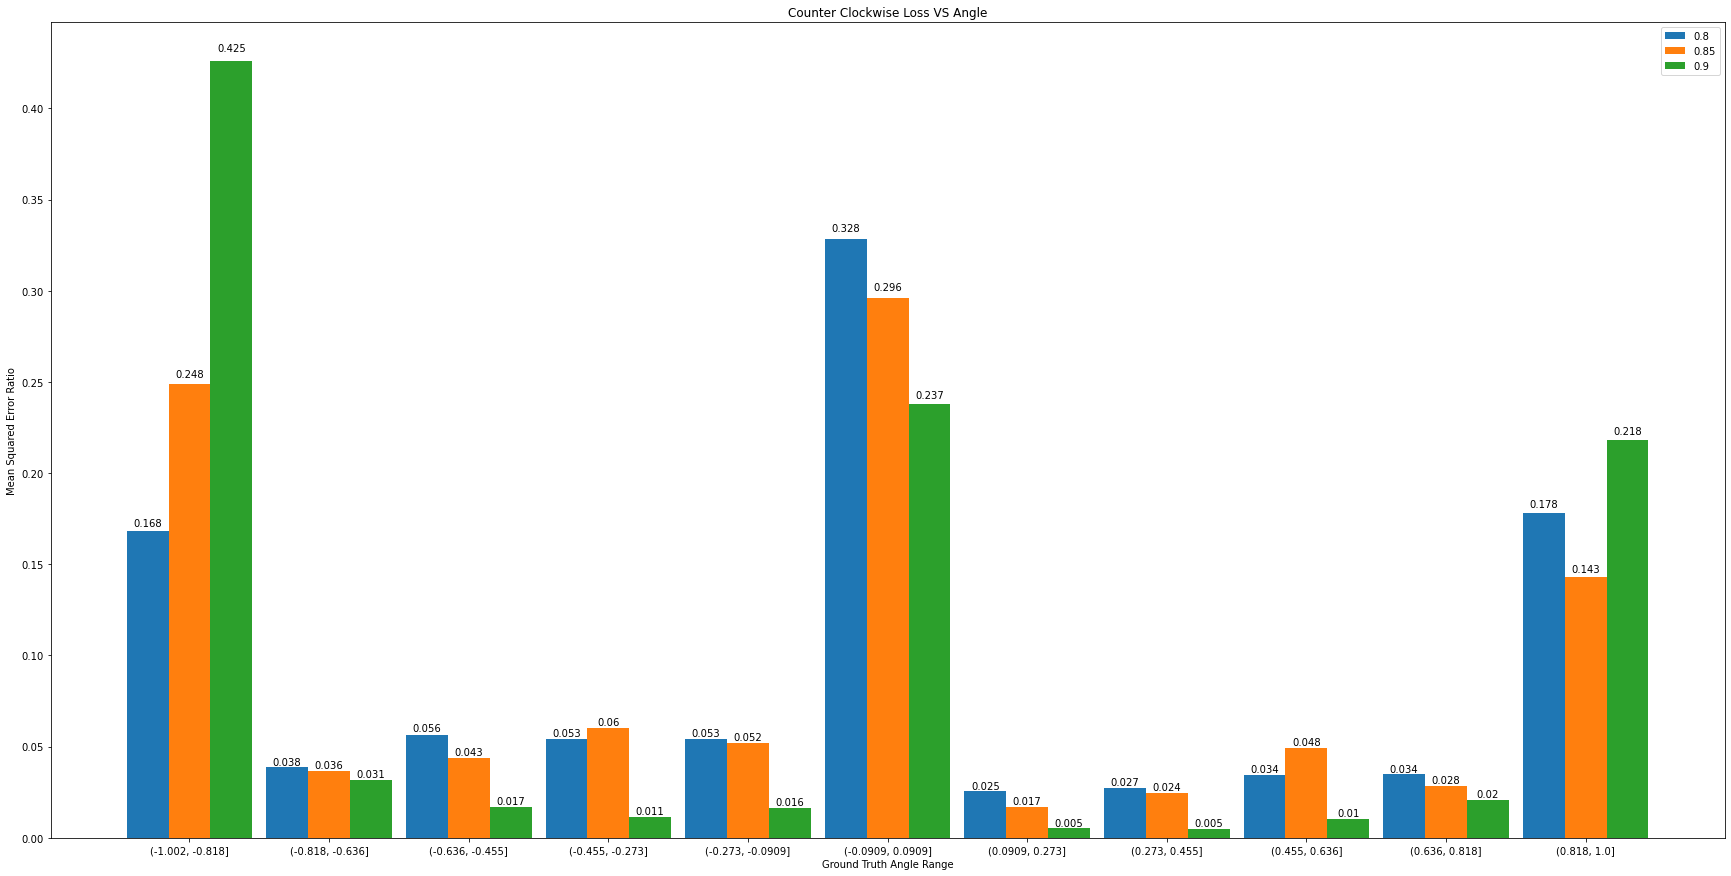

In [74]:
from matplotlib import pyplot as plt

def autolabel(rects, ax=None):
    if ax:
        plotting = ax
    else:
        plotting = plt
    for rect in rects:
        height = rect.get_height()
        plotting.text(rect.get_x() + rect.get_width()/2., 1.01*height, int(height*1000)/1000, ha='center', va='bottom')

def plot_angle_vs_error_ratios(df: pd.DataFrame, direction: str):
    plt.figure(figsize=(30,15))
    ind = np.arange(df.gt_bin.unique().size)
    width = 0.3

    for i, speed in enumerate([0.8, 0.85, 0.9]):
        speed_df = df[df.speed == speed]
        total_sum = speed_df.squared_error.sum()
        grouped = speed_df.groupby('gt_bin')
        group_sum = grouped.squared_error.sum()
        squared_error_ratios = group_sum / total_sum
        rects = plt.bar(i*width+ind, squared_error_ratios, label=speed, width=width)
        autolabel(rects)

    plt.xlabel('Ground Truth Angle Range')
    plt.ylabel('Mean Squared Error Ratio')
    plt.title(f'{direction} Loss VS Angle')

    plt.xticks(ind + width, squared_error_ratios.index)
    plt.legend(loc='best')
    plt.show()

plot_angle_vs_error_ratios(cc_df, 'Counter Clockwise')

## Plot histograms for ground truth and predictions for all 3 speeds for Counter Clockwise direction

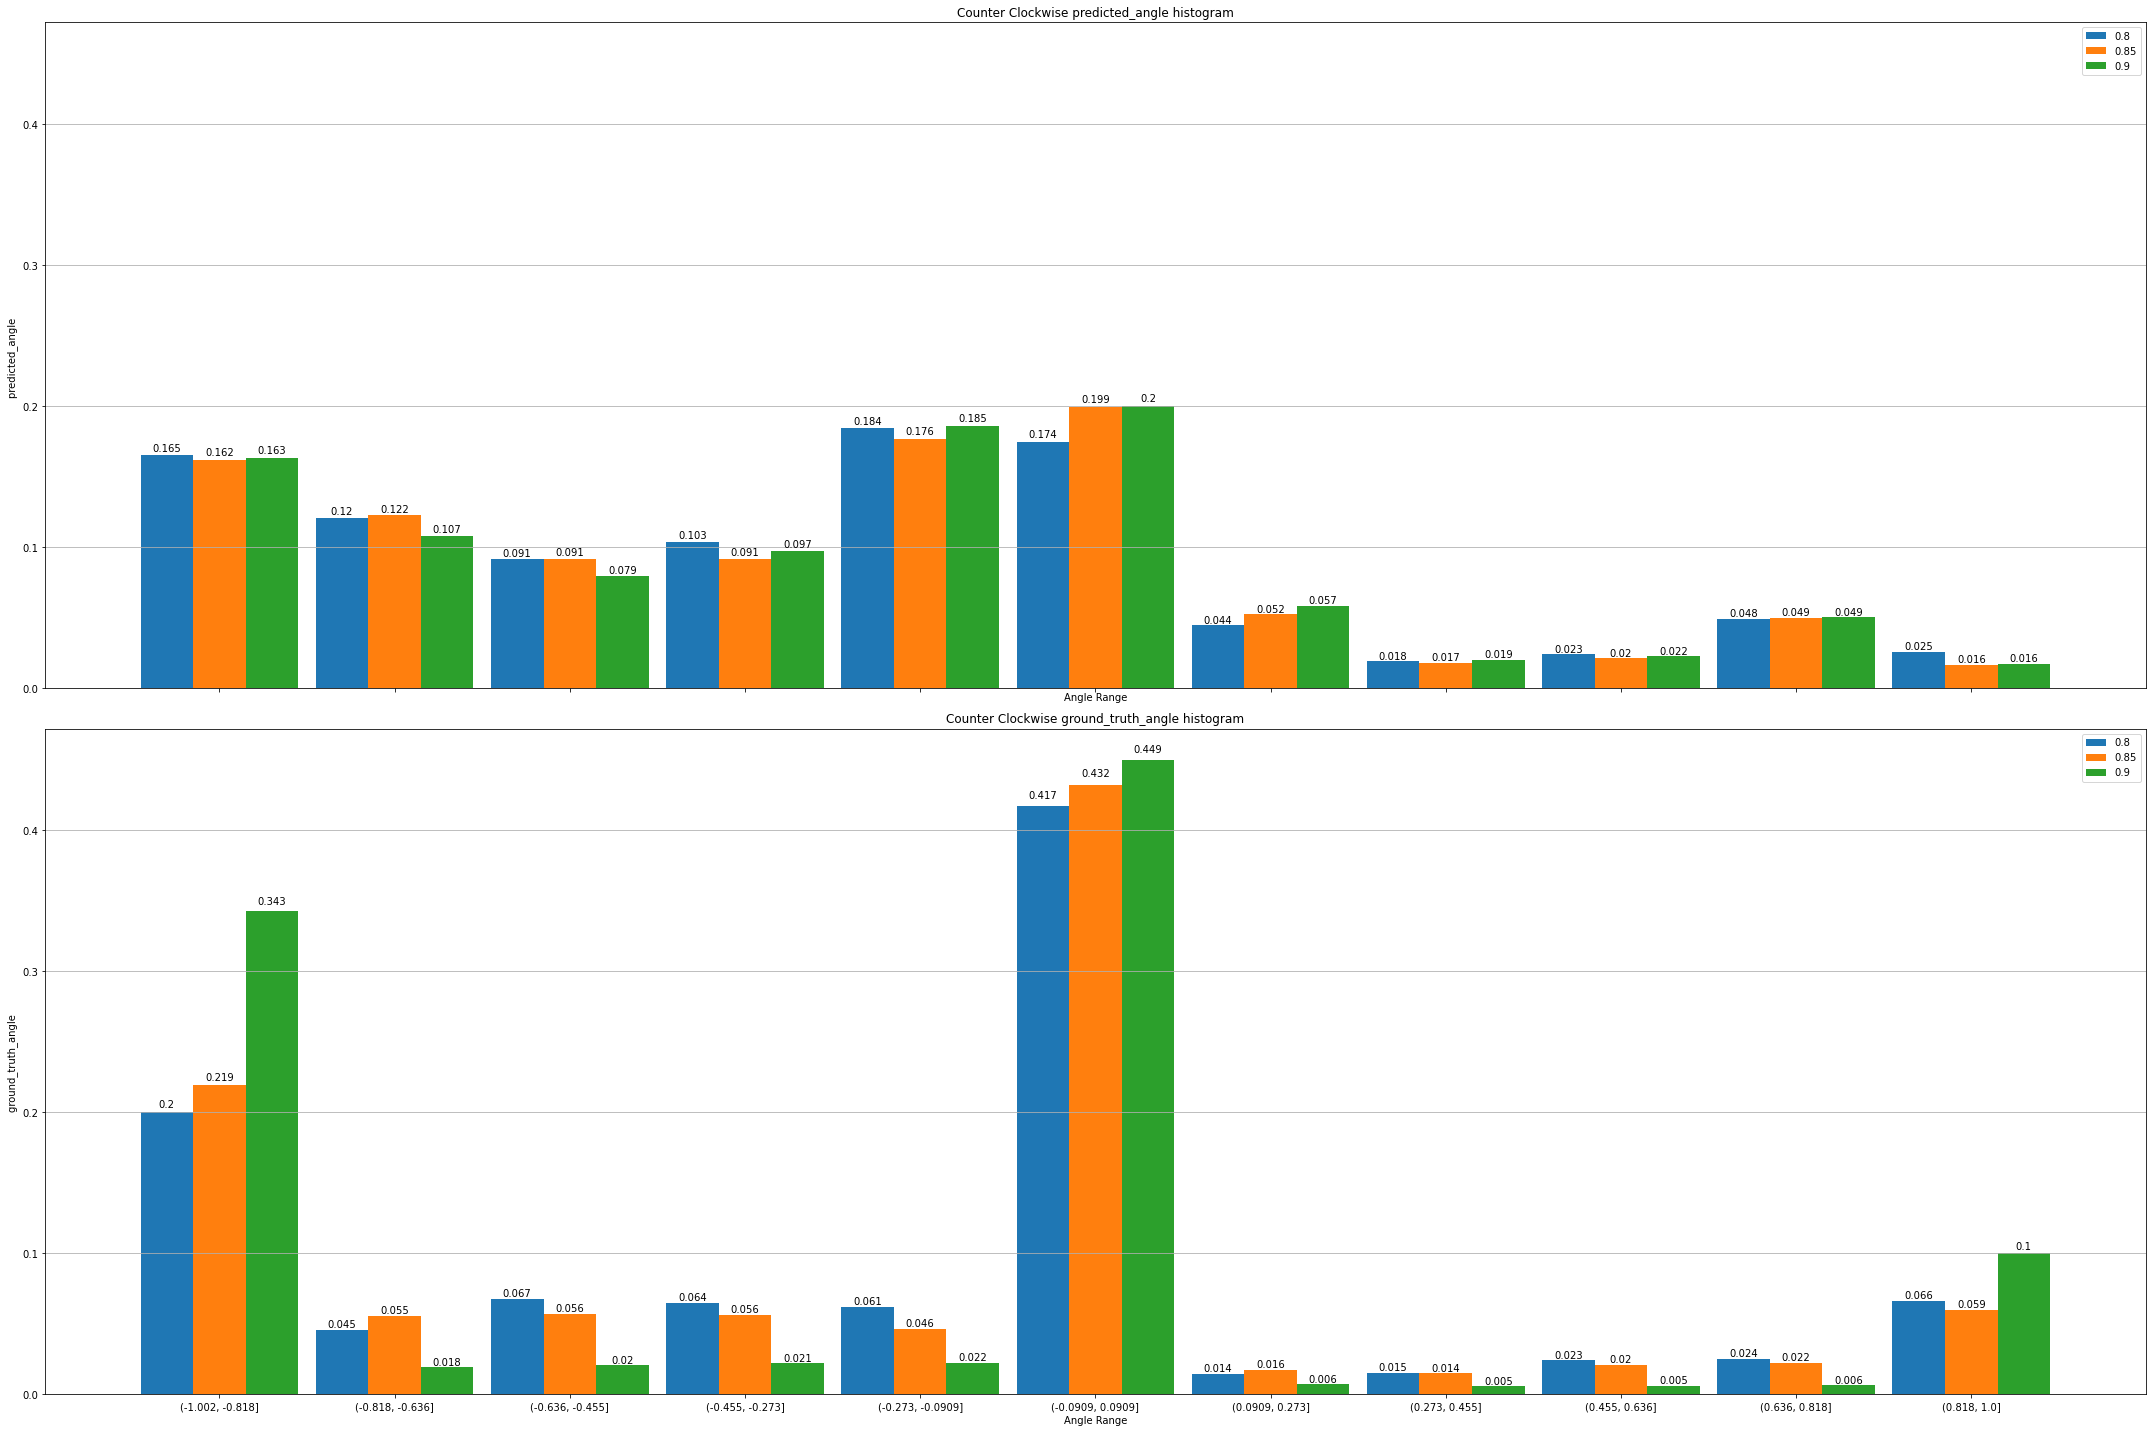

In [85]:
def plot_all_speed_histograms(ax, df: pd.DataFrame, direction: str, y_column_name: str, x_column_name: str):
    ind = np.arange(df.gt_bin.unique().size)
    width = 0.3

    for i, speed in enumerate([0.8, 0.85, 0.9]):
        speed_df = df[df.speed == speed]
        grouped = speed_df.groupby(x_column_name)
        total_count = speed_df[y_column_name].count()
        group_count = grouped[y_column_name].count()
        ratios = group_count / total_count
        rects = ax.bar(i*width+ind, ratios, label=speed, width=width)
        autolabel(rects, ax)

    ax.set(title=f'{direction} {y_column_name} histogram',
           ylabel=f'{y_column_name} ',
           xlabel='Angle Range',
           xticks = ind + width,
           xticklabels = ratios.index)

    ax.legend(loc='best')

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(30, 20), sharex='all', sharey='all')
for colnames, ax in zip([('predicted_angle', 'pred_bin'), ('ground_truth_angle', 'gt_bin')], axs.flat):
    ax.grid(True, axis='y')
    plot_all_speed_histograms(ax, cc_df, 'Counter Clockwise', colnames[0], colnames[1])

    ax.legend()
fig.tight_layout()
plt.show()

In [86]:
cw_df = df[(df.direction == 'CW') & (df.is_train == False)]
cw_df.groupby(['speed']).mean()

,fold,is_train,predicted_angle,ground_truth_angle,squared_error
speed,,,,,
0.80,3.000000,0.0,0.452853,0.344451,0.077670
0.85,3.000000,0.0,0.438068,0.355642,0.081828
0.90,2.999535,0.0,0.427889,0.384736,0.093599


## Plot squared error ratio for each bin for Clockwise data


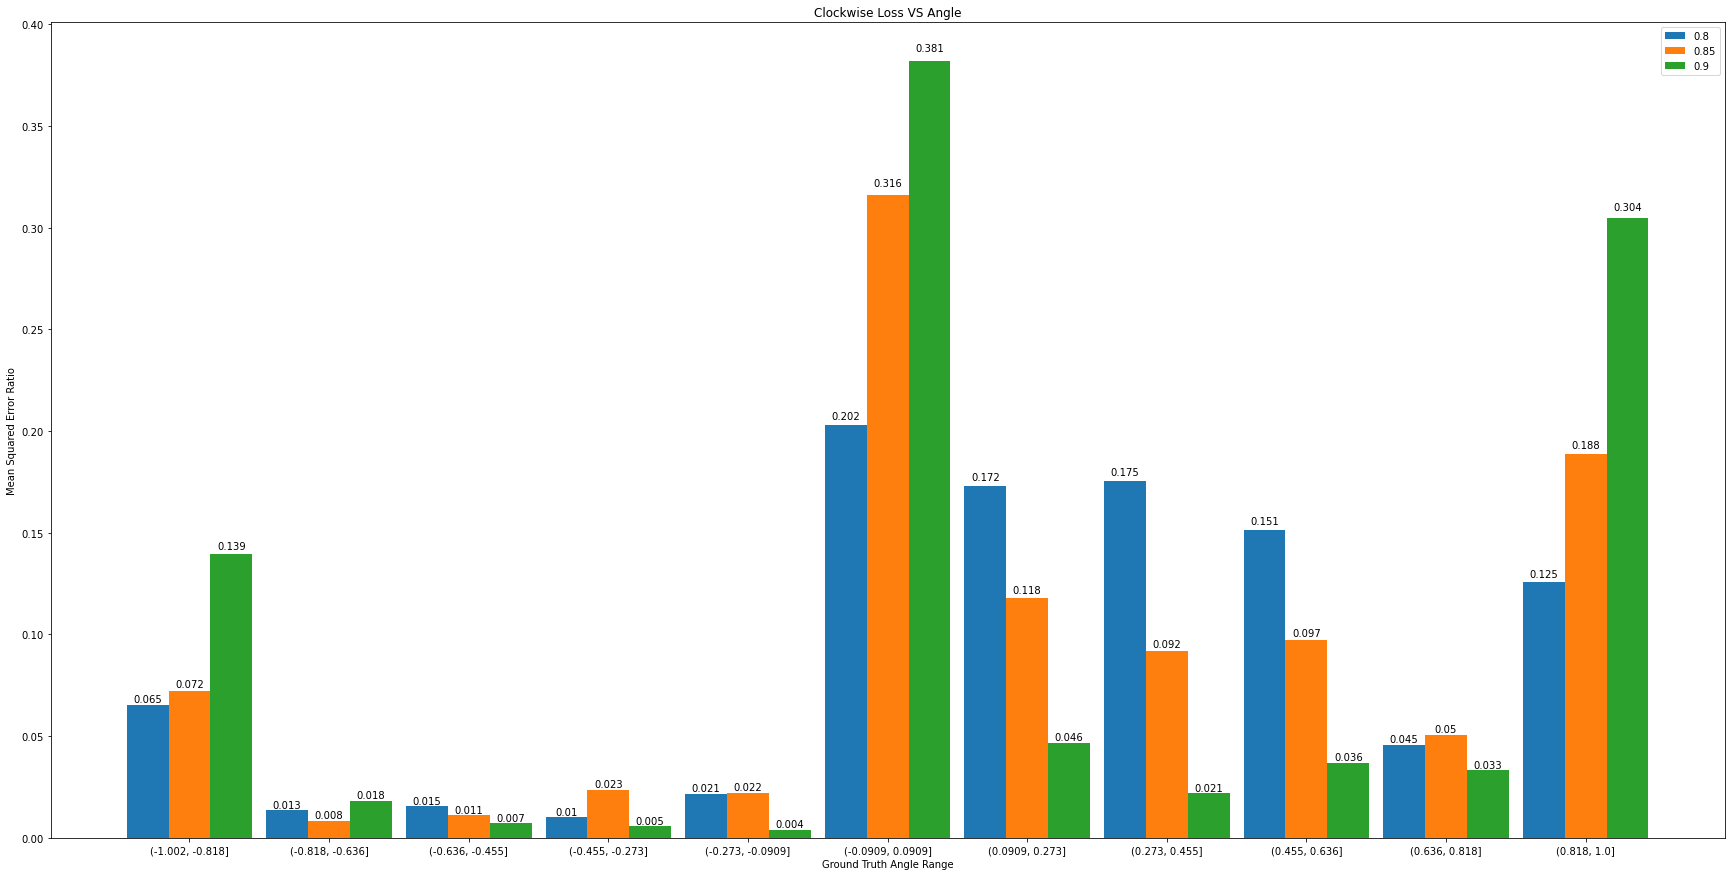

In [87]:
plot_angle_vs_error_ratios(cw_df, 'Clockwise')

## Plot histograms for ground truth and predictions for all 3 speeds for Clockwise direction

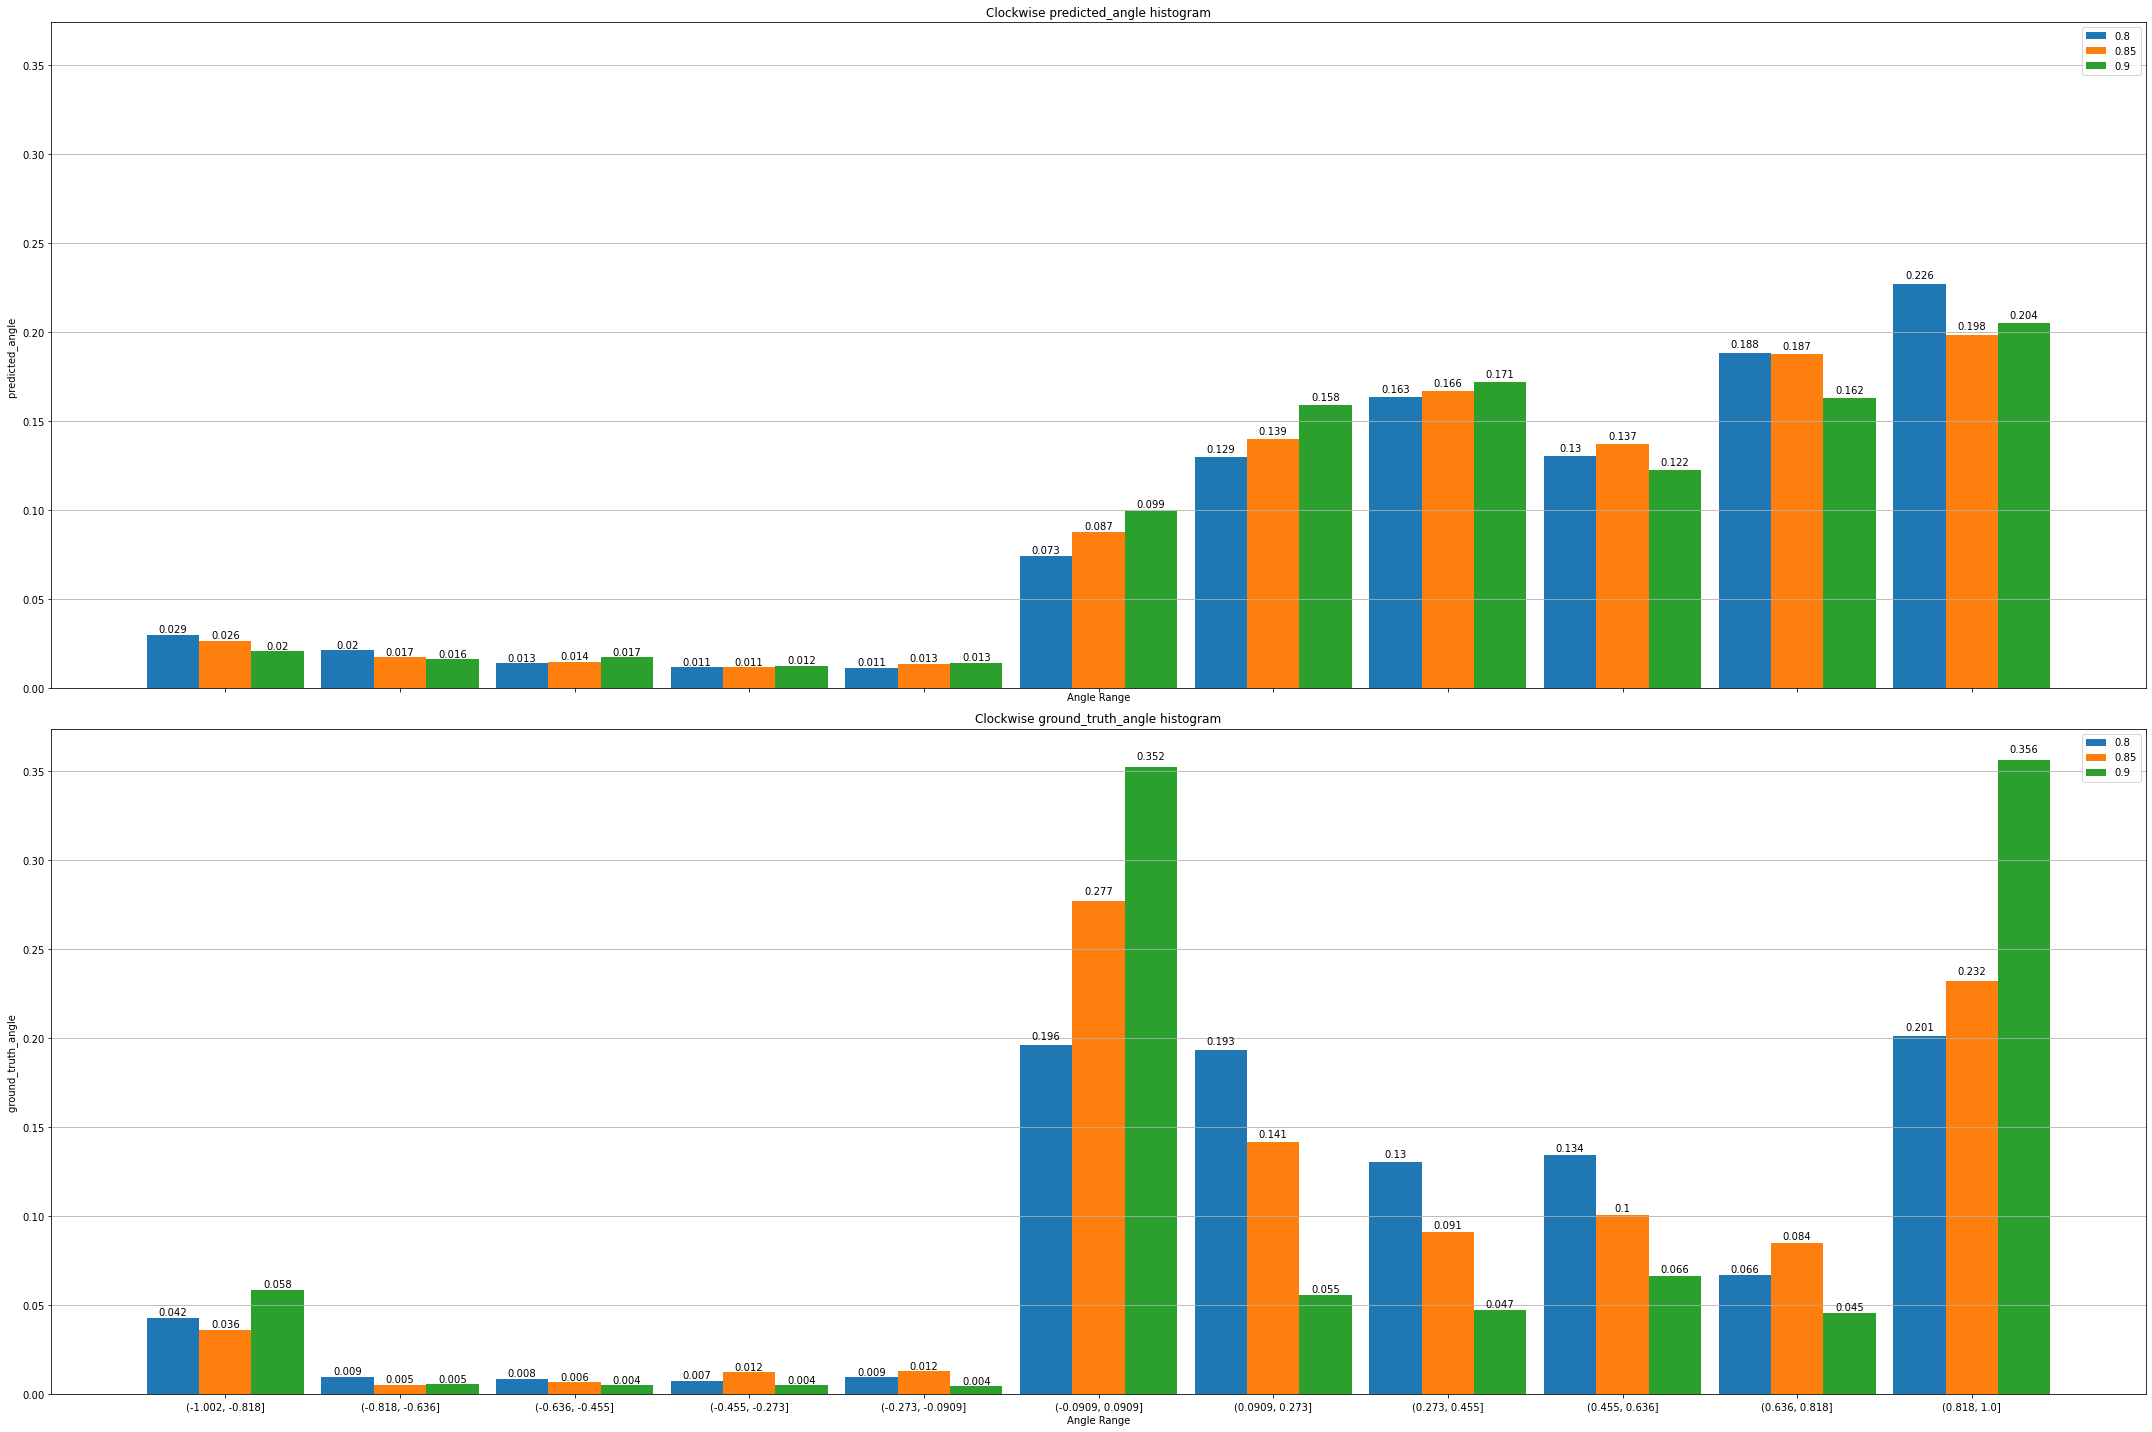

In [88]:

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(30, 20), sharex='all', sharey='all')
for colnames, ax in zip([('predicted_angle', 'pred_bin'), ('ground_truth_angle', 'gt_bin')], axs.flat):
    ax.grid(True, axis='y')
    plot_all_speed_histograms(ax, cw_df, 'Clockwise', colnames[0], colnames[1])

    ax.legend()
fig.tight_layout()
plt.show()


#### Conclusion
Yes, for slower speeds, the error is bigger for smaller angles, not far-right (+1) or far-left (-1).
The error is bigger for 0.9-speed for the maximum angle values, both, far-right and far-left.

Curiously, in the clockwkise direction, the center-area has a bigger error for 0.9-speed.